# Introduction

This notebook is the EDA for a Kaggle Competition called Linking Writing Processes to Writing Quality. Here is the description of the competition:

It’s difficult to summarize the complex set of behavioral actions and cognitive activities in the writing process. Writers may use different techniques to plan and revise their work, demonstrate distinct pause patterns, or allocate time strategically throughout the writing process. Many of these small actions may influence writing quality. Even so, most writing assessments focus on only the final product. Data science may be able to uncover key aspects of the writing process.
Past research explored a number of process features related to behaviors such as pausing, additions or deletions, and revisions. However, previous studies have used relatively small datasets. Additionally, only a small number of process features have been studie

#### This Notebook

This notebook only applies to the EDA, where we use an unsupervised approach to augment the data with clustering and through SVD/NMF models using sklearnd

In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn
!pip install numpy
!pip install pandas

In [1]:
#imports
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import NMF, PCA, TruncatedSVD
from sklearn.metrics import silhouette_score

os.environ['KERAS_BACKEND'] = 'tensorflow'


Using TensorFlow backend


# EDA

In [2]:
train_logs_path = './train_logs.csv'

train_logs = pd.read_csv(train_logs_path)
print('Training Logs Head')
print(train_logs.head())
print('--------------------------------------------------------------------------------------------------------------------')
print('Training Logs Info')
print(train_logs.info())
print('--------------------------------------------------------------------------------------------------------------------')
print('Training Logs Stats')
print(train_logs.describe())

Training Logs Head
         id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event  Filter text_change  text_change_len  cursor_position  \
0  Leftclick  Leftclick    True    NoChange              8.0                0   
1  Leftclick  Leftclick    True    NoChange              8.0                0   
2      Shift      Shift    True    NoChange              8.0                0   
3          q          q    True           q              1.0                1   
4          q          q    True           q              1.0                2   

   word_count  
0           0  
1           0  
2      

Text(0.5, 1.0, 'Distribution of scores')

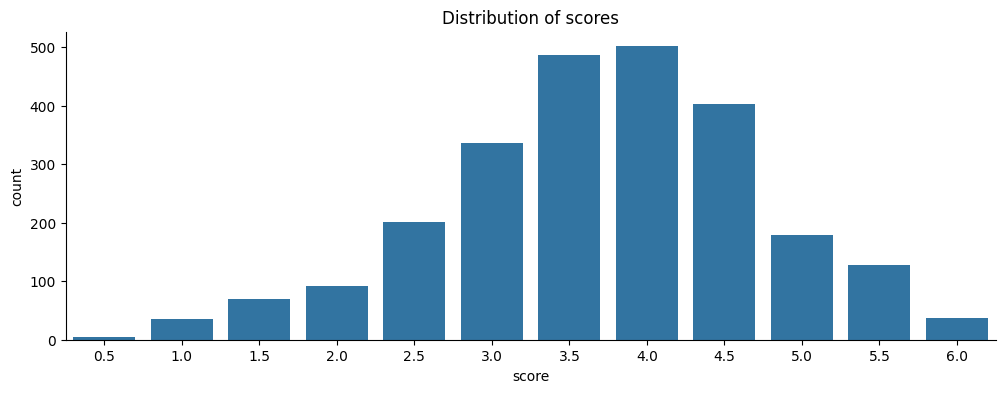

In [3]:
train_scores_path = './train_scores.csv'
train_scores = pd.read_csv(train_scores_path)
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_scores,
                   x="score")

ax.set_title("Distribution of scores")

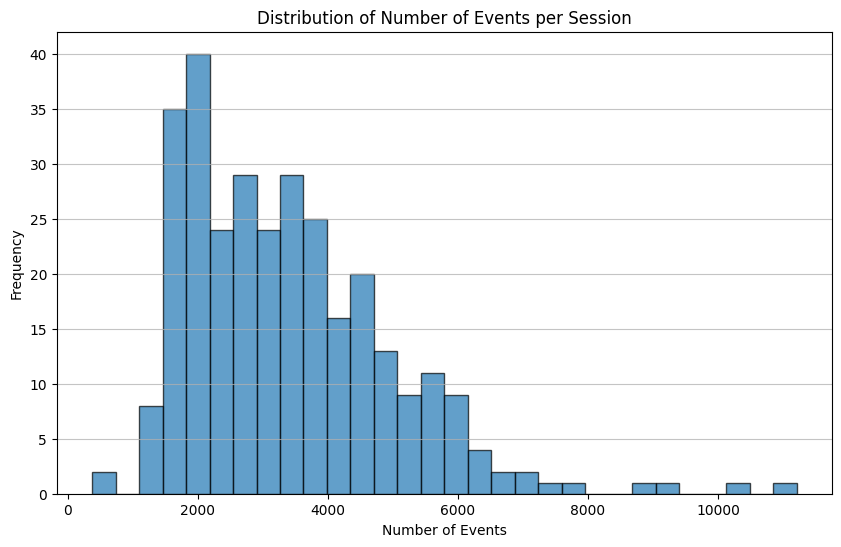

In [4]:
events_per_session = train_logs.groupby('id').size().reset_index(name='num_events')

plt.figure(figsize=(10, 6))
plt.hist(events_per_session['num_events'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Number of Events per Session')
plt.xlabel('Number of Events')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

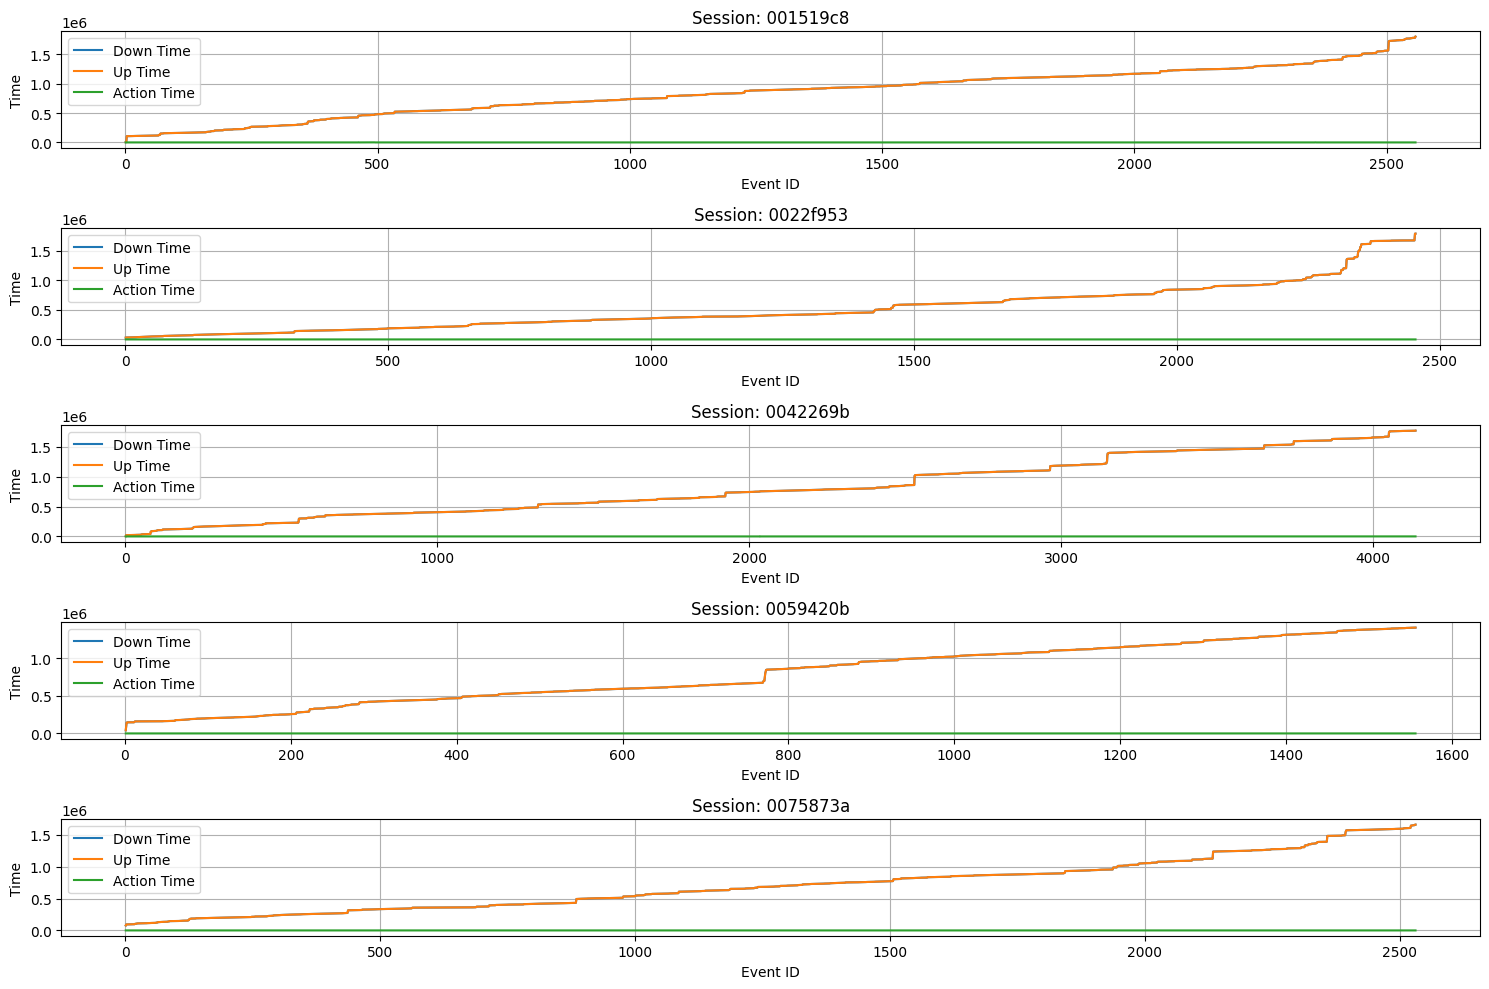

In [5]:
sample_sessions = train_logs['id'].unique()[:5]

plt.figure(figsize=(15, 10))

for i, session_id in enumerate(sample_sessions, 1):
    session_data = train_logs[train_logs['id'] == session_id].sort_values(by='event_id')
    
    plt.subplot(5, 1, i)
    plt.plot(session_data['event_id'], session_data['down_time'], label='Down Time')
    plt.plot(session_data['event_id'], session_data['up_time'], label='Up Time')
    plt.plot(session_data['event_id'], session_data['action_time'], label='Action Time')
    
    plt.title(f'Session: {session_id}')
    plt.xlabel('Event ID')
    plt.ylabel('Time')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Temporal maps that show the time for a sample of users. Up time is an accumulation and shows the total time taken to write

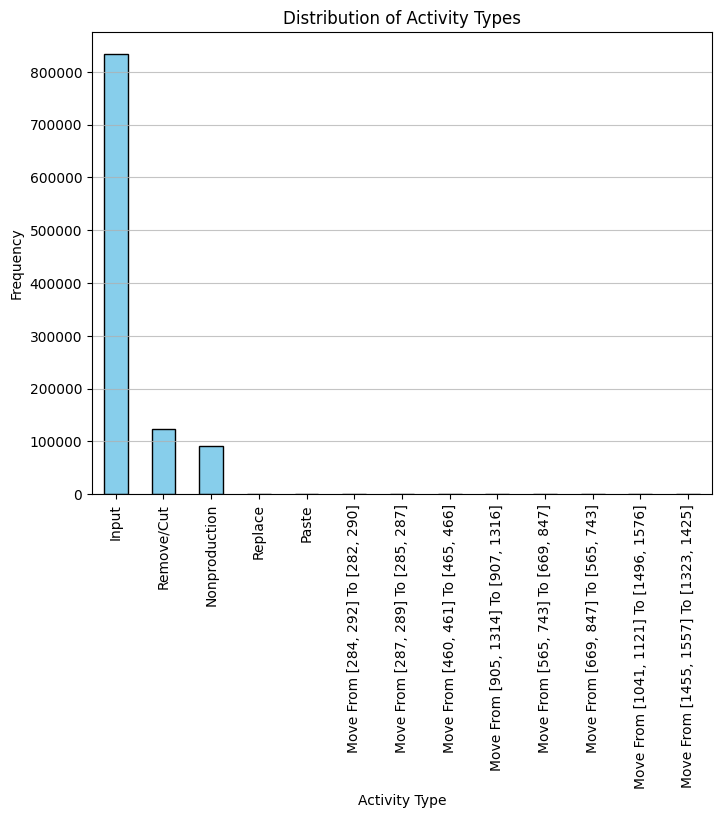

In [6]:
plt.figure(figsize=(8, 6))
train_logs['activity'].value_counts().plot(kind='bar', color='skyblue', edgecolor='k')
plt.title('Distribution of Activity Types')
plt.xlabel('Activity Type')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

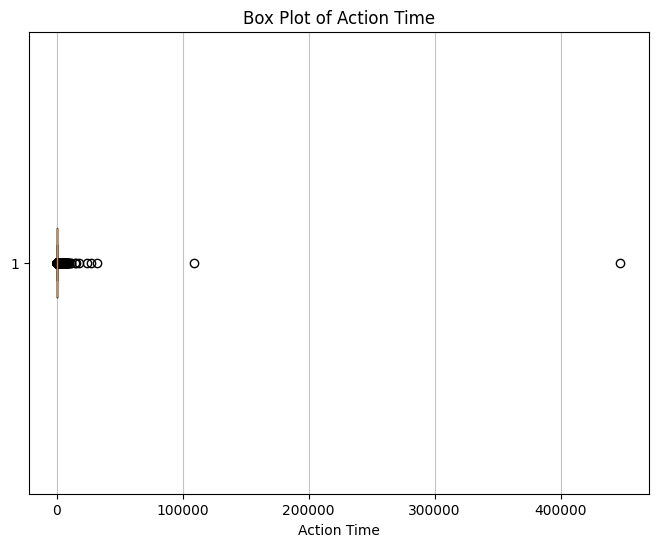

98.45481439095916 447470 93.0


In [7]:
plt.figure(figsize=(8, 6))
plt.boxplot(train_logs['action_time'], vert=False)
plt.title('Box Plot of Action Time')
plt.xlabel('Action Time')
plt.grid(axis='x', alpha=0.75)
plt.show()

action_time_mean = np.mean(train_logs['action_time'])
action_time_max = np.max(train_logs['action_time'])
action_time_median = np.median(train_logs['action_time'])
print(action_time_mean, action_time_max, action_time_median)

#There are some outliers here. I investigated and they come from holding down left click for a long time.
#i dont see why it should take 2-5 minutes to hold it down but idk how to deal with this

In [12]:
# Calculate the length of text changes
print('Longest Text Change: ', np.max(train_logs['text_change_len']))
print('Avg Text Change: ', np.mean(train_logs['text_change_len']))

Longest Text Change:  1275.0
Avg Text Change:  1.6490051698931212


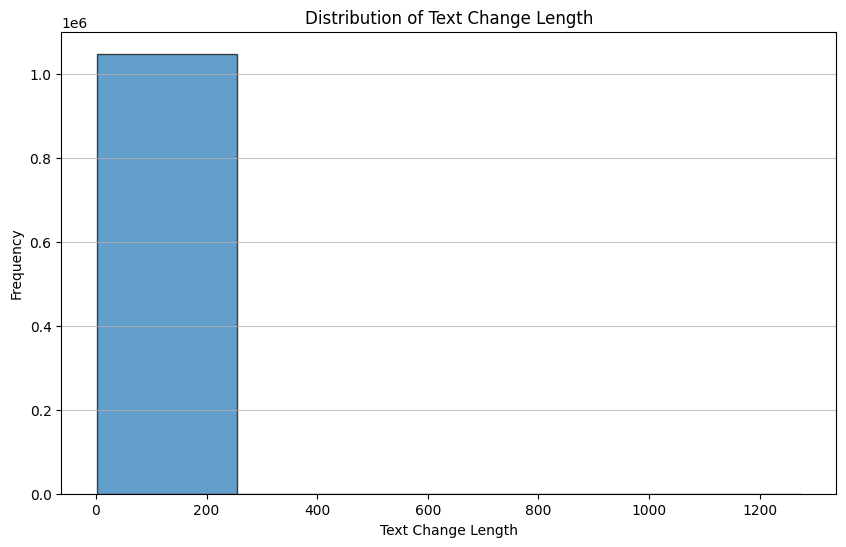

In [13]:
# Plot the distribution - length of text changes #DOESNT WORK BECAUSE INPUT IS SEEN AS ONE. NEED TO CLASSIFY WHETHER ACTION IS DONE OR NOT
plt.figure(figsize=(10, 6))
plt.hist(train_logs['text_change_len'], bins=5, edgecolor='k', alpha=0.7)
plt.title('Distribution of Text Change Length')
plt.xlabel('Text Change Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

#Outlier here in length of text change. Seems to be a really large one at 1275 and the rest are mostly 1 (because one letter at a time)
#So it appears someone replaced a large amount of their data at once.

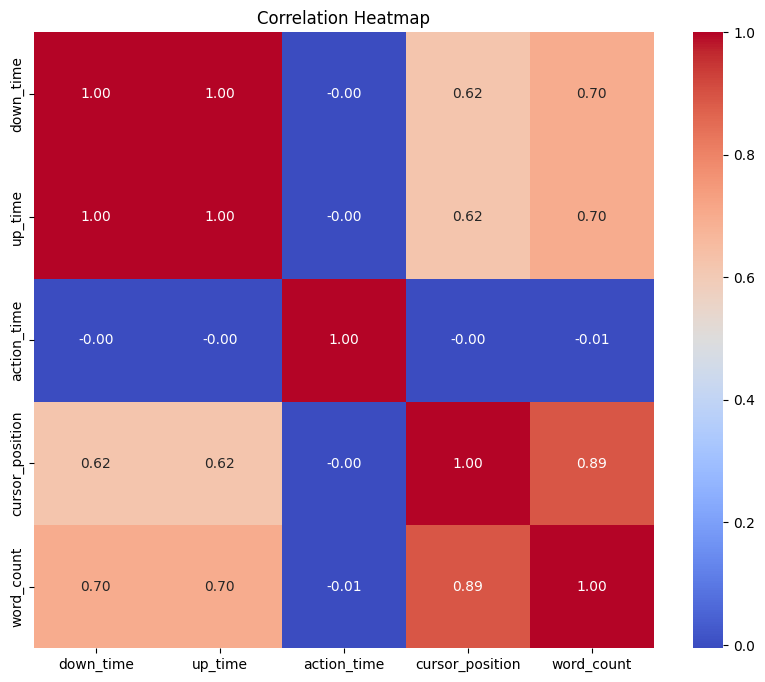

In [14]:
# Calculate correlations
corr_matrix = train_logs[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Score for 001519c8 : 3.5


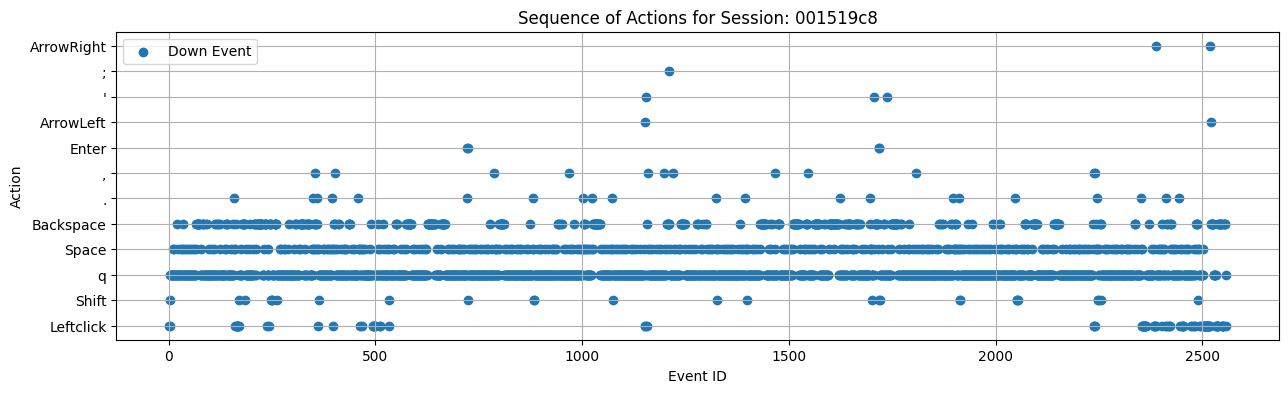

Score for 0022f953 : 3.5


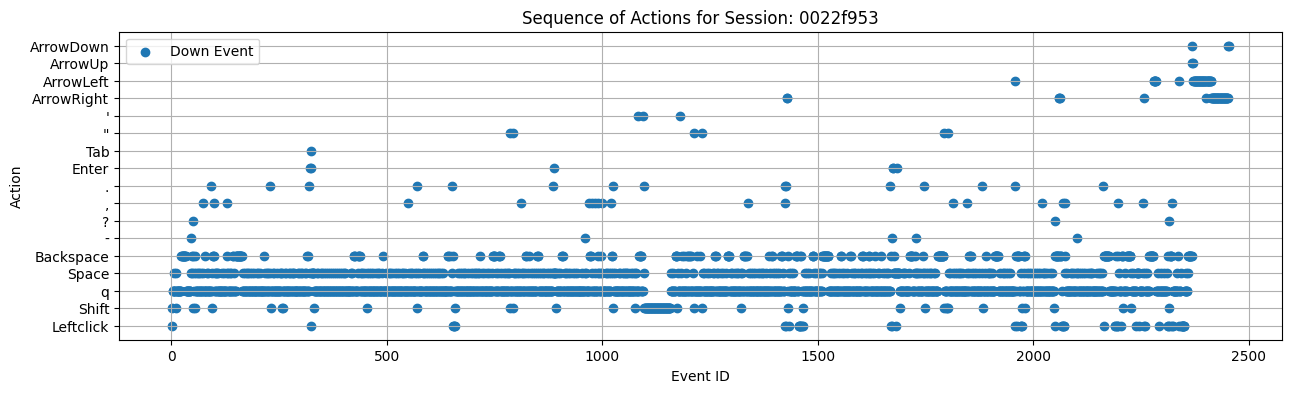

Score for 0042269b : 6.0


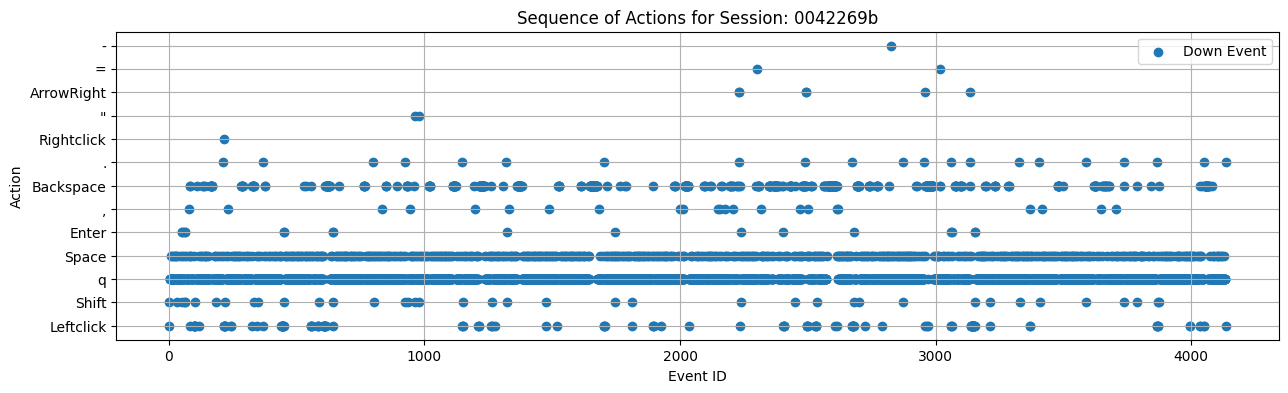

Score for 0059420b : 2.0


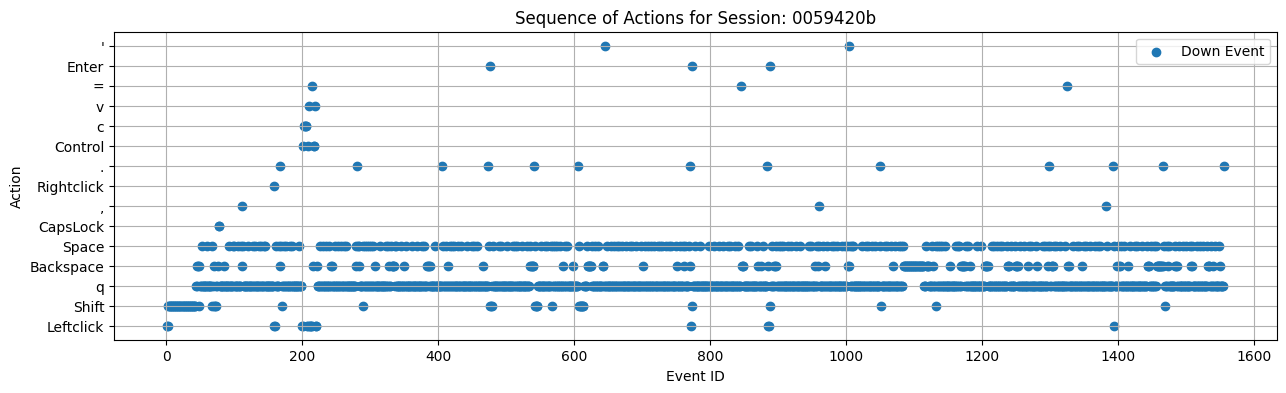

Score for 0075873a : 4.0


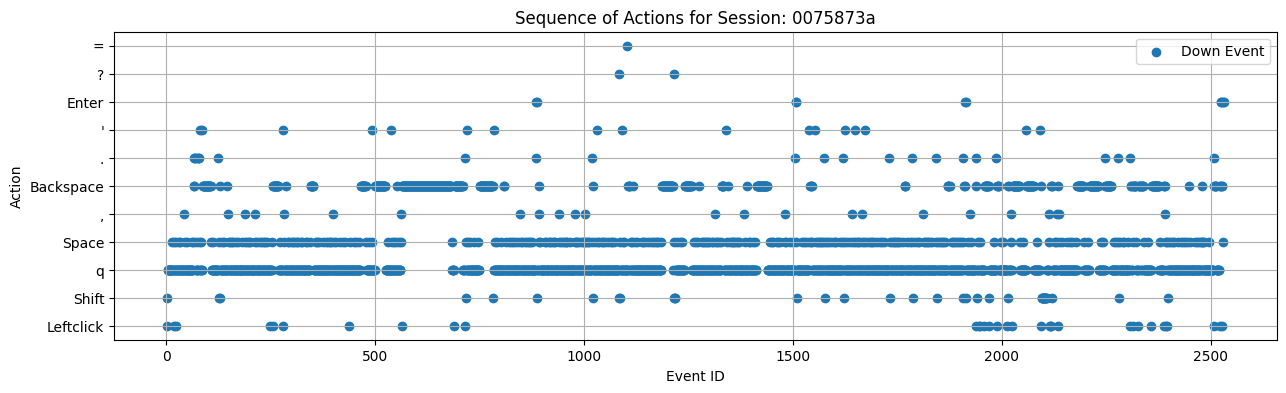

In [15]:
# Plot sequence of actions for sample sessions
for session_id in sample_sessions:
    # Retrieve and print the score for the current session_id
    score_for_session = train_scores.loc[train_scores['id'] == session_id, 'score'].values[0]
    print('Score for', session_id, ':', score_for_session)
    session_data = train_logs[train_logs['id'] == session_id].sort_values(by='event_id')
    
    plt.figure(figsize=(15, 4))
    plt.scatter(session_data['event_id'], session_data['down_event'], label='Down Event')
    plt.title(f'Sequence of Actions for Session: {session_id}')
    plt.xlabel('Event ID')
    plt.ylabel('Action')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
#Outlier in sequence length -> the Starter Notebook used SEQ_LENGTH < 1700. This one goes to 11 211, meaning that there are outliers.

print("Mean: ", np.mean(train_logs['event_id']))
print("Median: ", np.median(train_logs['event_id']))

Mean:  2076.753556970174
Median:  1729.0


# Unsupervised Learning

In [17]:
categorical_cols = ['activity', 'down_event', 'up_event', 'text_change']
numerical_cols = ['down_time', 'up_time', 'action_time', 'text_change_len', 'cursor_position', 'word_count']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


nmf = NMF(n_components=12, max_iter=5000, random_state=0)

# Collect features
nmf_features = []
labels = []

mean_score = train_scores['score'].mean()
default_score = round(mean_score * 2) / 2
for user_id in train_logs['id'].unique():
    user_data = preprocessor.fit_transform(train_logs[train_logs['id'] == user_id])
    user_nmf_features = nmf.fit_transform(user_data)
    
    if user_id in train_scores['id'].values:
        user_score = train_scores[train_scores['id'] == user_id]['score'].values[0]
    else:
        user_score = default_score # Use default score -> mean rounded to nearest 0.5

    nmf_features.append(user_nmf_features)
    labels.append(user_score)

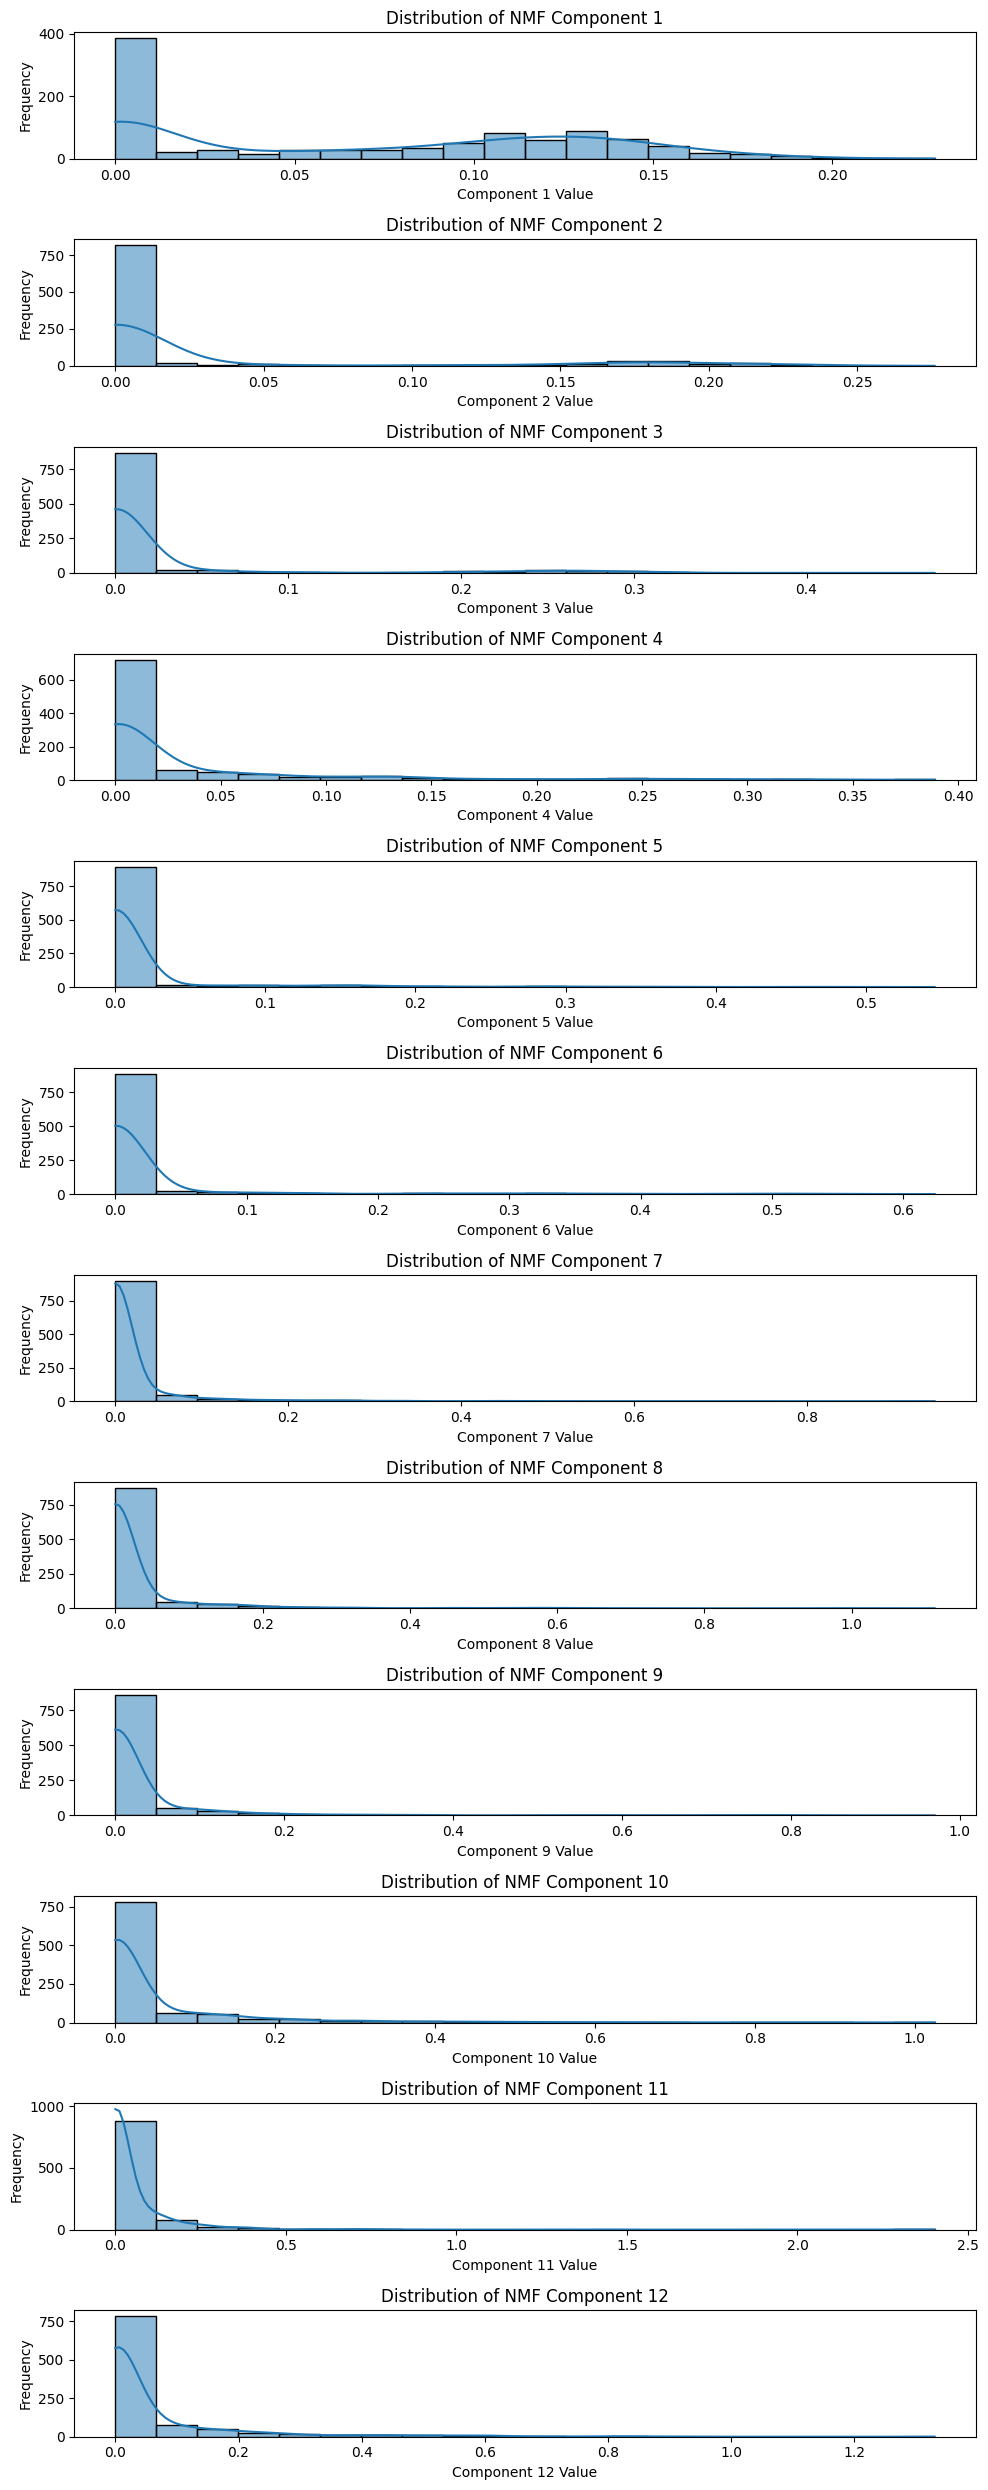

In [18]:
# Plotting
nmf_features_df = pd.DataFrame(np.vstack(nmf_features), columns=[f'NMF_Component_{i}' for i in range(1, 13)])
sample_ids = np.random.choice(nmf_features_df.index, size=1000, replace=False) 
sampled_nmf_features = nmf_features_df.loc[sample_ids]
fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(10, 25))
for i, ax in enumerate(axes):
    sns.histplot(sampled_nmf_features[f'NMF_Component_{i+1}'], bins=20, kde=True, ax=ax)
    ax.set_title(f'Distribution of NMF Component {i+1}')
    ax.set_xlabel(f'Component {i+1} Value')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [20]:
# Try random states. Convert this to a proper search later
# Compare to SVD
components_list = []
for i in range(5):  # Number of iterations
    print(i)
    nmf_features = []
    labels = []
    nmf = NMF(n_components=12, max_iter=4000, random_state=i)
    svd = TruncatedSVD(n_components=12, random_state=i)
    mean_score = train_scores['score'].mean()
    default_score = round(mean_score * 2) / 2
    for user_id in train_logs['id'].unique():
        user_data = preprocessor.fit_transform(train_logs[train_logs['id'] == user_id])
        user_nmf_features = nmf.fit_transform(user_data)
        user_svd_features = svd.fit_transform(user_data)
        
        if user_id in train_scores['id'].values:
            user_score = train_scores[train_scores['id'] == user_id]['score'].values[0]
        else:
            user_score = default_score # Use default score -> mean rounded to nearest 0.5
    
        nmf_features.append(user_nmf_features)
        labels.append(user_score)

    nmf_reconstruction_error = nmf.reconstruction_err_
    
    print("SVD Expalined Variance Ratio", svd.explained_variance_ratio_)
    print("NMF Reconstruction Error:", nmf_reconstruction_error)
    components_list.append(nmf.components_)

0
SVD Expalined Variance Ratio [2.04675044e-01 3.38272129e-01 2.29293802e-01 1.09524429e-01
 6.15602503e-02 1.83719071e-02 1.52545035e-02 9.12288035e-03
 7.47496959e-03 4.76737970e-03 1.52243402e-03 1.60271374e-04]
NMF Reconstruction Error: 0.690056131038388
1
SVD Expalined Variance Ratio [2.04675044e-01 3.38272129e-01 2.29293802e-01 1.09524429e-01
 6.15602503e-02 1.83719071e-02 1.52545035e-02 9.12288035e-03
 7.47496959e-03 4.76737970e-03 1.52243402e-03 1.60271374e-04]
NMF Reconstruction Error: 0.6900561310383908
2
SVD Expalined Variance Ratio [2.04675044e-01 3.38272129e-01 2.29293802e-01 1.09524429e-01
 6.15602503e-02 1.83719071e-02 1.52545035e-02 9.12288035e-03
 7.47496959e-03 4.76737970e-03 1.52243402e-03 1.60271374e-04]
NMF Reconstruction Error: 0.6900561310383889
3
SVD Expalined Variance Ratio [2.04675044e-01 3.38272129e-01 2.29293802e-01 1.09524429e-01
 6.15602503e-02 1.83719071e-02 1.52545035e-02 9.12288035e-03
 7.47496959e-03 4.76737970e-03 1.52243402e-03 1.60271374e-04]
NMF Re

# Results

The NMF Model gives a Reconstruction Error of 0.69. This means that it does an okay job of reconstructing the data after being reduced. The SVD looks at the variance in components and the first 6 components cover 88% of the variance so I think that will also be useful to have.

# Discussion

The NMF Reconstruction Error is 0.69 which isnt great but the dataset we have is kinda lacking in data for the task we are asked in the competition so I will take any type of data augmentation. Also, for the SVD components, i will also use this in my Neural Network for the competition. I plan on doing both separately and then again together. Hopefully this will help the Neural Network understand some latent features in the data.